## Imports

### modules

In [8]:
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from cv2 import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, RandomFlip, RandomContrast, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner import HyperParameters, RandomSearch



C:\Users\Chris\AppData\Local\Temp\ipykernel_115252\1797482214.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband


In [3]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[0], 'GPU')

### data

In [4]:
dataset_path = "../../data/meta/final_dataset_raw.csv"
image_folder_path = "../../data/images/"

In [5]:
df = pd.read_csv(dataset_path, index_col=0)
df

,name,car_name,car_type,is_test
1,00002_Acura TL Sedan 2012.jpg,Acura TL Sedan 2012,Sedan,0
2,00003_Dodge Dakota Club Cab 2007.jpg,Dodge Dakota Club Cab 2007,Pickup,0
3,00004_Hyundai Sonata Hybrid Sedan 2012.jpg,Hyundai Sonata Hybrid Sedan 2012,Sedan,0
4,00005_Ford F-450 Super Duty Crew Cab 2012.jpg,Ford F-450 Super Duty Crew Cab 2012,Pickup,0
5,00006_Geo Metro Convertible 1993.jpg,Geo Metro Convertible 1993,Convertible,0
...,...,...,...,...
26212,RamCVCargoVanMinivan201294.jpeg,Ram C/V Cargo Van Minivan 2012,Minivan,1
26213,RamCVCargoVanMinivan201296.jpeg,Ram C/V Cargo Van Minivan 2012,Minivan,1
26214,RamCVCargoVanMinivan201297.jpeg,Ram C/V Cargo Van Minivan 2012,Minivan,1
26215,RamCVCargoVanMinivan201298.jpeg,Ram C/V Cargo Van Minivan 2012,Minivan,1


## Prepare data

### split data into train, validation and test set

In [6]:
def split_data(dataset: tf.data.Dataset, val: float, test: float) -> dict: 
    total_length = len(dataset)
    train_size = int(total_length * (1 - (val + test)))
    val_siize = int(total_length * val) +1 
    test_size = int(total_length * test) +1 

    train_data = dataset.take(train_size)
    val_data = dataset.skip(train_size).take(val_siize)
    test_data = dataset.skip(train_size + val_siize).take(test_size)


    sets = {"training": train_data, 
            "validation": val_data, 
            "testing": test_data
            }
    
    return sets

In [6]:
# initialize data generator for augmentation and dataset creation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=17,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)


### load actual images

In [7]:
dataset = datagen.flow_from_directory(
    image_folder_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42,
)
# dataset = tf.keras.utils.image_dataset_from_directory(directory=image_folder_path, seed=42)

# Convert the generator iterator to a tf.data.Dataset

Found 17815 images belonging to 3 classes.


In [8]:
# batch = dataset.next()
train_set = datagen.flow_from_directory(image_folder_path,
                                              target_size = (256, 256),
                                              color_mode = "rgb",
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

val_set = datagen.flow_from_directory(image_folder_path,
                                              target_size = (256,256),
                                              color_mode = "rgb",
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='validation',
                                              shuffle=False)

Found 14253 images belonging to 3 classes.
Found 3562 images belonging to 3 classes.


d:\anaconda3\envs\tf_env\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
d:\anaconda3\envs\tf_env\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


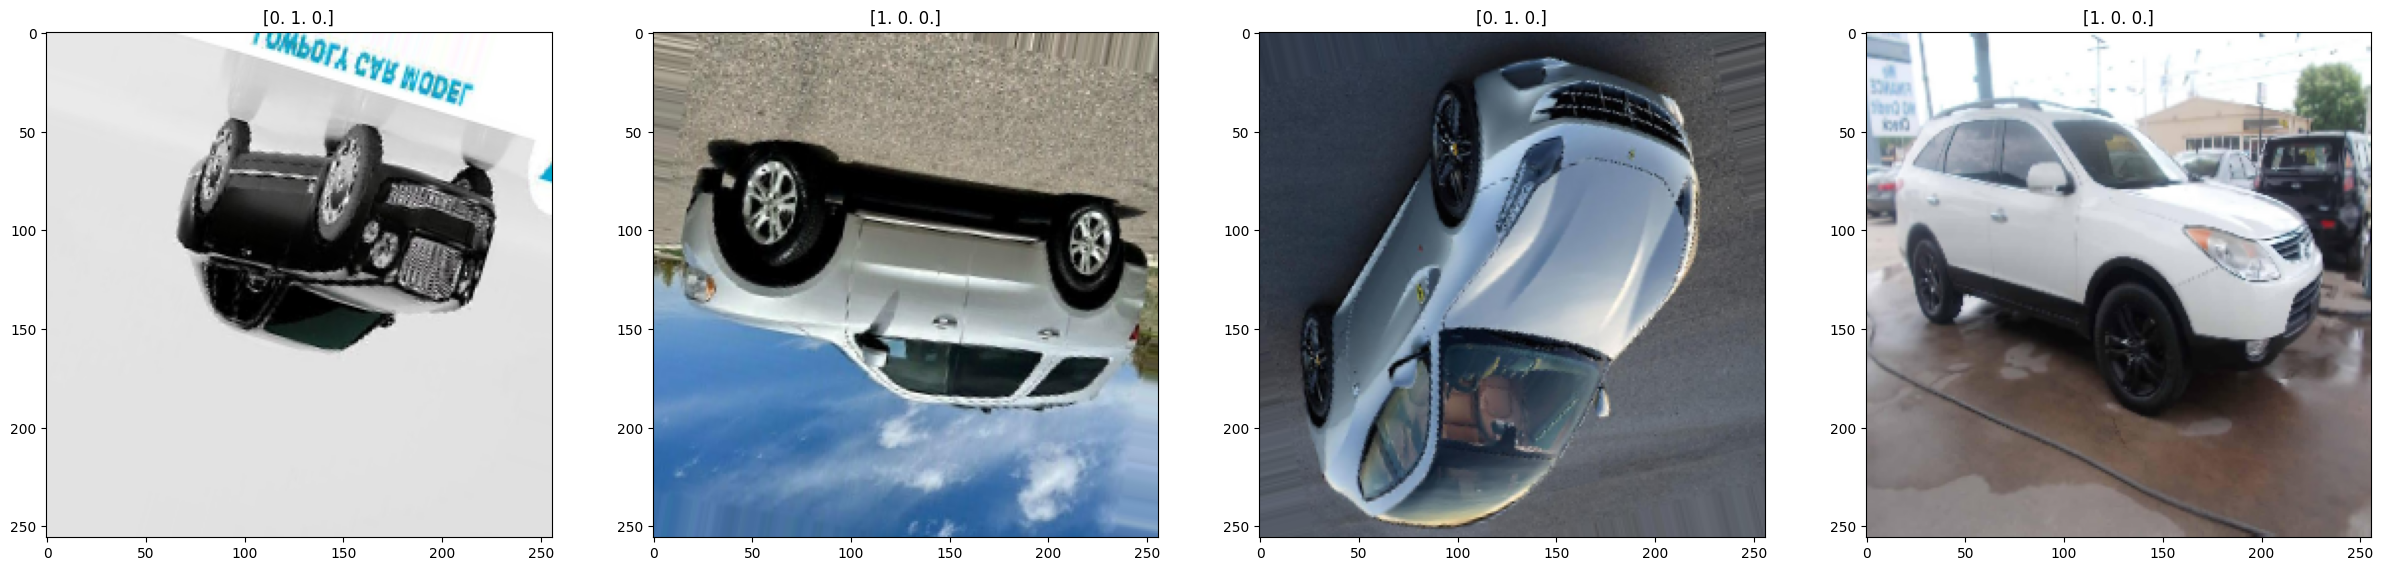

In [78]:
fig, ax = plt.subplots(ncols=4, figsize=(30, 30))
for index, image in enumerate(train_set.next()[0][:4]): 
    ax[index].imshow(image)
    ax[index].title.set_text(train_set.next()[1][index])

    # 0 = large 
    # 1 = Midsize 
    # 2 small 

In [10]:
# #normalize the images / batches 
# normalized_data = dataset.map(lambda x,y: (x/255.0, y))
# noemalized_batch = normalized_data.as_numpy_iterator().next()

In [11]:
# fig, ax = plt.subplots(ncols=4, figsize=(30, 30))
# for index, image in enumerate(noemalized_batch[0][:4]): 
#     ax[index].imshow(image)
#     ax[index].title.set_text(batch[1][index])

#     # 0 = large 
#     # 1 = Midsize 
#     # 2 small 

In [12]:
# splits = split_data(normalized_data, 0.15, 0.05)
# train_data = splits["training"]
# val_data = splits["validation"]
# test_data = splits["testing"]

### training set augmentation

## Building the model

### build the CNN

In [23]:

import tensorflow as tf

hp = HyperParameters()
hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
hp.Choice('batch_size', values=[16, 32])
hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
hp.Int("dense_neurons", min_value=256, max_value=1024, step=128)
hp.Float("regularization_l", min_value=0.01, max_value=0.035, step=0.05)

def build_model(hp):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(hp.get("dense_neurons"), kernel_regularizer=tf.keras.regularizers.l2(l=hp.get("regularization_l")),
    activity_regularizer=tf.keras.regularizers.l1(hp.get("regularization_l")),
              bias_regularizer=tf.keras.regularizers.l1(hp.get("regularization_l")), activation='relu')(x)
    x = Dropout(rate=hp.get('dropout_rate'), seed=42)(x)
    output = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    optimizer = Adamax(learning_rate=hp.get('learning_rate'))
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    hyperparameters=hp,
    directory='model_params',
    project_name='car_body_params'
)


# base_model=EfficientNetB0(include_top=False, weights="imagenet",input_shape=(256, 256, 3), pooling='max') 
# x = base_model.output

# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
# x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(l = 0.025),activity_regularizer=tf.keras.regularizers.l1(0.008),
#                 bias_regularizer=tf.keras.regularizers.l1(0.006) ,activation='relu')(x)
# x = tf.keras.layers.Dropout(rate=0.3, seed=42)(x)   
# output = tf.keras.layers.Dense(3, activation='softmax')(x)
# model = tf.keras.Model(inputs=base_model.input, outputs=output)
# model.compile(tf.keras.optimizers.Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

# model.summary()

# model = Sequential([Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)),
#                     MaxPooling2D(),
#                     Conv2D(32, (3, 3), 1, activation="relu"),
#                     MaxPooling2D(),
#                     Conv2D(16, (3, 3), 1, activation="relu"), 
#                     MaxPooling2D(), 
#                     Flatten(), 
#                     Dense(256, activation="relu"), 
#                     Dense(1, activation="sigmoid")])

# model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# model.summary()


In [24]:
# # hist = model.fit(train_data, epochs=20, validation_data=val_data)
# history = model.fit(train_set, 
#                     validation_data = val_set,
#                     epochs = 20,
#                     batch_size = 32)

# Perform the hyperparameter search
tuner.search(train_set, validation_data=val_set, epochs=20, batch_size=32)

# Get the best hyperparameters and build the final model
best_hp = tuner.get_best_hyperparameters(1)[0]


Trial 10 Complete [00h 59m 09s]
val_accuracy: 0.5873104929924011

Best val_accuracy So Far: 0.8997753858566284
Total elapsed time: 09h 31m 49s
INFO:tensorflow:Oracle triggered exit


In [35]:
final_model = tuner.hypermodel.build(best_hp)
tuner.results_summary()

Results summary
Results in model_params\car_body_params
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
learning_rate: 0.0002115705594649727
batch_size: 32
dropout_rate: 0.2
dense_neurons: 512
regularization_l: 0.01
Score: 0.8997753858566284

Trial 05 summary
Hyperparameters:
learning_rate: 0.0001656118230010775
batch_size: 16
dropout_rate: 0.4
dense_neurons: 896
regularization_l: 0.01
Score: 0.883773148059845

Trial 04 summary
Hyperparameters:
learning_rate: 0.0004126407644629029
batch_size: 32
dropout_rate: 0.0
dense_neurons: 768
regularization_l: 0.01
Score: 0.880685031414032

Trial 08 summary
Hyperparameters:
learning_rate: 0.0006166547518927783
batch_size: 16
dropout_rate: 0.30000000000000004
dense_neurons: 1024
regularization_l: 0.01
Score: 0.8590679168701172

Trial 03 summary
Hyperparameters:
learning_rate: 0.0005703556236244591
batch_size: 32
dropout_rate: 0.1
dense_neurons: 384
regularization_l: 0.01
Score: 0.8217293620

In [36]:
hist = final_model.fit(train_set, validation_data=val_set, epochs=20)

Epoch 1/20
446/446 [==============================] - 176s 379ms/step - loss: 8.5278 - accuracy: 0.6578 - val_loss: 6.6527 - val_accuracy: 0.4599
Epoch 2/20
446/446 [==============================] - 168s 375ms/step - loss: 5.7569 - accuracy: 0.7368 - val_loss: 5.2488 - val_accuracy: 0.5051
Epoch 3/20
446/446 [==============================] - 161s 361ms/step - loss: 4.4300 - accuracy: 0.7812 - val_loss: 4.2011 - val_accuracy: 0.5626
Epoch 4/20
446/446 [==============================] - 169s 379ms/step - loss: 3.4694 - accuracy: 0.8087 - val_loss: 3.3362 - val_accuracy: 0.6305
Epoch 5/20
446/446 [==============================] - 165s 370ms/step - loss: 2.7158 - accuracy: 0.8241 - val_loss: 2.4890 - val_accuracy: 0.7771
Epoch 6/20
446/446 [==============================] - 165s 370ms/step - loss: 2.1331 - accuracy: 0.8395 - val_loss: 2.6743 - val_accuracy: 0.4585
Epoch 7/20
446/446 [==============================] - 167s 375ms/step - loss: 1.6758 - accuracy: 0.8577 - val_loss: 1.9099 -

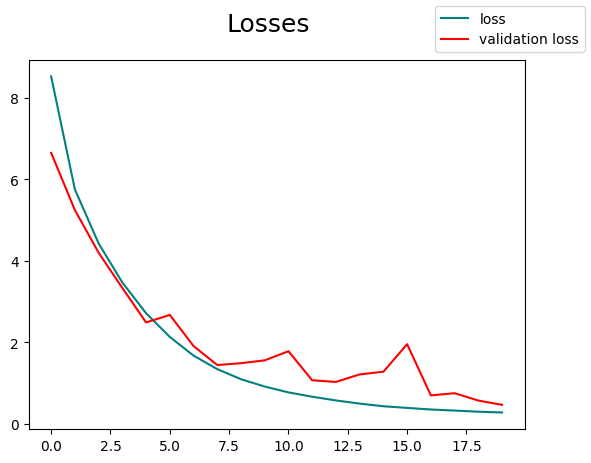

In [37]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="red", label="validation loss")
fig.suptitle("Losses", fontsize=18)
fig.legend(loc="upper right")
plt.show()

In [65]:
final_model.save_weights("./model_params/car_body_params/trial_00/weights.h5")

In [9]:
import json

# Load the hyperparameters from the trials.json file
with open("./model_params/car_body_params/trial_00/trial.json", 'r') as file:
    trials_data = json.load(file)

# Extract the hyperparameter values
hyperparameters = trials_data['hyperparameters']['values']
learning_rate = hyperparameters['learning_rate']
batch_size = hyperparameters['batch_size']
dropout_rate = hyperparameters['dropout_rate']
dense_neurons = hyperparameters['dense_neurons']
regularization_l = hyperparameters['regularization_l']

# Build your model using the extracted hyperparameter values
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3), pooling='max')
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(dense_neurons, kernel_regularizer=tf.keras.regularizers.l2(l=regularization_l),
          activity_regularizer=tf.keras.regularizers.l1(regularization_l),
          bias_regularizer=tf.keras.regularizers.l1(regularization_l), activation='relu')(x)
x = Dropout(rate=dropout_rate, seed=42)(x)
output = Dense(3, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=output)
optimizer = Adamax(learning_rate=learning_rate)
model.load_weights("./model_params/car_body_params/trial_00/weights.h5")
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                              

1/1 [==============================] - 0s 35ms/step


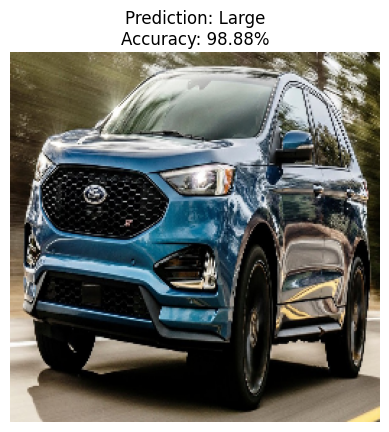

In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
image_path = './Ford-Edge-ST-02.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = cv2.resize(image, (256, 256))  # Resize the image to match the model's input shape
image = image / 255.0  # Normalize the pixel values

# Reshape the image to match the input shape expected by the model
image = np.expand_dims(image, axis=0)

# Perform prediction
predictions = model.predict(image)
predicted_class_index = np.argmax(predictions, axis=1)

# Get the predicted class label
class_labels = ['Large', 'Midsize', 'Small']
predicted_class_label = class_labels[predicted_class_index[0]]

# Get the model accuracy
accuracy = predictions[0][predicted_class_index[0]] * 100

# Create the plot
plt.imshow(image[0])
plt.title('Prediction: {}\nAccuracy: {:.2f}%'.format(predicted_class_label, accuracy))
plt.axis('off')
plt.show()
